In [2]:
from gym_road_cars import CarRacing
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.contrib.distributions.python.ops import relaxed_onehot_categorical

In [3]:
env = CarRacing(num_bots=0, start_file=None)
env.reset()

(array([[[177, 165, 147],
         [177, 165, 147],
         [177, 165, 147],
         ...,
         [141, 125, 102],
         [140, 123, 102],
         [140, 123, 102]],
 
        [[175, 163, 145],
         [175, 163, 145],
         [175, 163, 145],
         ...,
         [140, 124, 101],
         [140, 123, 102],
         [140, 123, 102]],
 
        [[173, 161, 143],
         [173, 161, 143],
         [173, 161, 143],
         ...,
         [136, 122,  99],
         [139, 122, 101],
         [139, 122, 101]],
 
        ...,
 
        [[ 99,  97,  86],
         [ 99,  97,  86],
         [100,  98,  87],
         ...,
         [ 43,  44,  34],
         [ 47,  48,  39],
         [ 50,  51,  42]],
 
        [[ 99,  97,  87],
         [100,  98,  88],
         [101,  99,  89],
         ...,
         [ 48,  49,  40],
         [ 49,  49,  43],
         [ 53,  53,  47]],
 
        [[ 99,  97,  87],
         [100,  98,  88],
         [101,  99,  89],
         ...,
         [ 41,  42,  33],
  

In [4]:
env.state[1]

array([32.        ,  2.79500008,  1.55242538])

In [326]:
env.state_coord

array([32.        ,  2.79500008,  1.55242538])

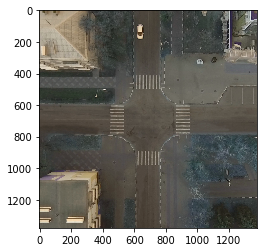

In [20]:
plt.imshow(init_state[0])
plt.show()

In [24]:
goal_poly

array([[40.  , -5.59],
       [40.  ,  0.  ],
       [37.  ,  0.  ],
       [37.  , -5.59]])

In [25]:
list(map(int, init_state[1]))

[2, -32, 0]

In [12]:
list(env.car.hull.position)

[32.0, 2.7950000762939453]

In [ ]:
%%time

env = CarRacingHackaton(num_bots=0, start_file=None)
init_state = env.reset()

env

plt.ion()

for i in range(400):
    state, reward, _, _ = env.step(3)
    print(env.target, reward)
    if i % 50 == 0:
        plt.imshow(state[0])
        plt.show()

target: 36, start: (-1.5707963267948966, -32.0, -2.795)


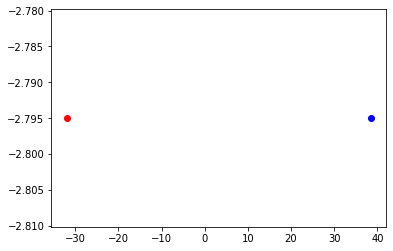

target: 96, start: (3.141592653589793, -2.795, 32.0)


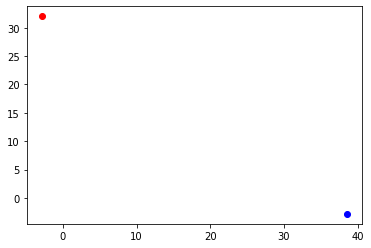

target: 38, start: (-1.5707963267948966, -32.0, -2.795)


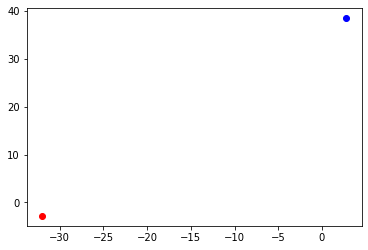

target: 78, start: (1.5707963267948966, 32.0, 2.795)


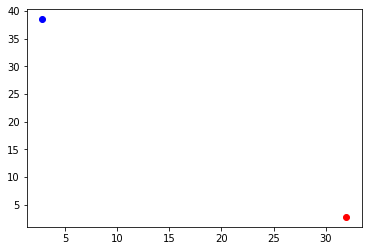

target: 96, start: (3.141592653589793, -2.795, 32.0)


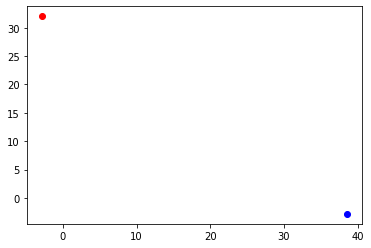

target: 36, start: (-1.5707963267948966, -32.0, -2.795)


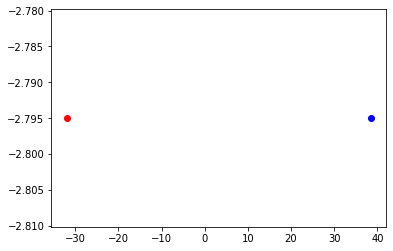

target: 92, start: (3.141592653589793, -2.795, 32.0)


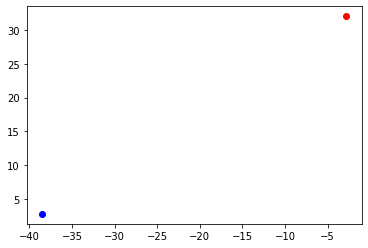

target: 58, start: (0, 2.795, -32.0)


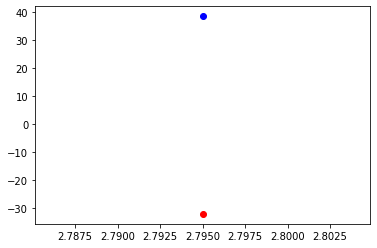

target: 78, start: (1.5707963267948966, 32.0, 2.795)


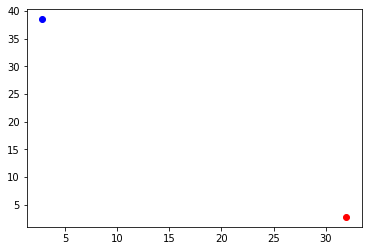

target: 36, start: (-1.5707963267948966, -32.0, -2.795)


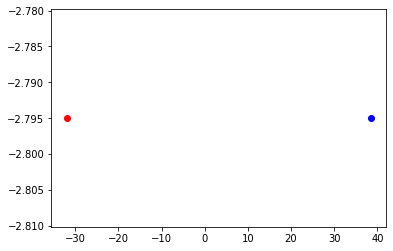

In [351]:
init_pos = []
goal_pos = []

for i in range(10):
    env = CarRacingHackaton(num_bots=0, start_file=None)
    init_state = env.reset()
    plt.scatter(init_state[1][0], init_state[1][1], color='red')
    goal = np.array(env.car_goal_poly)
    plt.scatter(np.mean(goal[:, 0]), np.mean(goal[:, 1]), color='blue')
    plt.show()

In [6]:
init_pos

array([[ -2.79500008,  32.00000381],
       [  2.79500008, -32.        ],
       [ 32.        ,   2.79500008],
       ...,
       [ -2.79500008,  32.00000381],
       [ -2.79500008,  32.00000381],
       [ 32.        ,   2.79500008]])

In [303]:
plt.scatter(init_pos[:, 0], init_pos[:, 1], color='red')
plt.scatter(goal_pos[:, 0], goal_pos[:, 1], color='blue')

NameError: name 'init_pos' is not defined

In [2]:
class SAC__Base:
    
    def copy_weights_from_model(self, other_model, transform_func=None):
        if transform_func is None:
            transform_func = lambda w_new, w_old: w_new
        update_weights = [
            tf.assign(old, transform_func(new, old))
            for (old, new) 
            in zip(
                tf.trainable_variables(self.scope_name),
                tf.trainable_variables(other_model.scope_name)
            )
        ]
        self.session.run(update_weights)
            
    def get_variables(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.scope_name)
    
    
    def load_from_file(self, path, file_name):
        saver = tf.train.import_meta_graph(file_name + '.meta')
        saver.restore(
            self.session,
            tf.train.latest_checkpoint(path),
        )
    
    def save_to_file(self, file_name):
        saver = tf.train.Saver(self.get_variables())
        saver.save(self.session, file_name)

In [3]:
class SAC__ValueNet(SAC__Base):
    
    def __init__(self, session, state_size, action_size, hidden_size=128, name='_v1'):
        self.session = session
        self.scope_name = 'SAC__ValueNet' + name
        
        with tf.variable_scope(self.scope_name):
            # V-value architecture from just two FC layer with relu activation
            self.state = tf.placeholder(
                dtype=tf.float32, 
                shape=[None, state_size], 
                name='ValueNet_state'
            )
            # (None, state_size) -> (None, hidden_size)
            x = tf.layers.Dense(units=hidden_size, activation='relu')(self.state)
            # (hidden_size, state_size) -> (None, hidden_size)
            x = tf.layers.Dense(units=hidden_size, activation='relu')(x)
            # (hidden_size, state_size) -> (None, 1)
            self.value = tf.layers.Dense(units=1, activation=None)(x)
            
            # place holder for `Q(s, a) - log(pi(a|s))`
            self.target = tf.placeholder(
                dtype=tf.float32,
                shape=[None, 1],
                name='ValueNet_target'
            )
            # use stop gradient to prevent the gradient spreading to target, that is `Q(s, a) - log(pi(a|s))`
            loss = 0.5 * tf.reduce_mean( (self.value - tf.stop_gradient(self.target))**2 )
            self.optimizer = tf.train.AdamOptimizer(0.003)
            
            # minimizing step over trainable params in this scope
            self.train_step = self.optimizer.minimize(
                loss,
                var_list=self.get_variables(),
            )
    
    def get_variables(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.scope_name)
            
    def get_value(self, state):
        return self.session.run(
            self.value,
            feed_dict={
                self.state: state,
            },
        )

    def make_update_step(self, state, target):
        self.session.run(
            self.train_step,
            feed_dict={
                self.state: state,
                self.target: target,
            }
        )

In [4]:
class SAC__QNet(SAC__Base):
    def __init__(self, session, state_size, action_size, hidden_size=128, name='_v1'):
        self.session = session
        self.scope_name = 'SAC__QNet' + name
        
        with tf.variable_scope(self.scope_name):
            # net architecture
            self.state = tf.placeholder(
                dtype=tf.float32,
                shape=[None, state_size],
                name='QNet_state'
            )
            self.action = tf.placeholder(
                dtype=tf.float32,
                shape=[None, action_size],
                name='QNet_action'
            )
            
            x_state = tf.layers.Dense(units=hidden_size, activation='relu')(self.state)
            x_action = tf.layers.Dense(units=hidden_size, activation='relu')(self.action)
            
            x = tf.concat([x_state, x_action], axis=1)
            x = tf.layers.Dense(units=hidden_size, activation='relu')(x)
            x = tf.layers.Dense(units=hidden_size, activation='relu')(x)
            # final shape [None, 1]
            self.qvalue = tf.layers.Dense(units=1)(x)
            
            self.optimizer = tf.train.AdamOptimizer(0.003)
            
            # here one should set target as `r(s_t, a_t) + gamma * V(s_{t+1})`
            self.target = tf.placeholder(
                dtype=tf.float32,
                shape=[None, 1],
                name='QNet_target'
            )
            loss = tf.reduce_mean( (self.qvalue - tf.stop_gradient(self.target))**2 )
            self.train_step = self.optimizer.minimize(
                loss,
                var_list=self.get_variables(),
            )

    def get_q(self, state, action):
        return self.session.run(
            self.qvalue,
            feed_dict={
                self.state: state,
                self.action: action,
            },
        )

    def make_update_step(self, state, action, target):
        self.session.run(
            self.train_step,
            feed_dict={
                self.state: state,
                self.action: action,
                self.target: target,
            },
        )

In [5]:
class SAC__Policy(SAC__Base):
    def __init__(self, session, state_size, action_size, hidden_size=128, name='_v1'):
        self.session = session
        self.scope_name = 'SAC__Policy' + name
        
        with tf.variable_scope(self.scope_name):
            # net architecture
            self.state = tf.placeholder(
                dtype=tf.float32,
                shape=[None, state_size],
                name='Policy_state'
            )
            self.action = tf.placeholder(
                dtype=tf.float32,
                shape=[None, action_size],
                name='Policy_action'
            )
            
            x = tf.layers.Dense(units=hidden_size, activation='relu')(self.state)
            x = tf.layers.Dense(units=hidden_size, activation='relu')(x)
            # final shape [None, 1]
            x = tf.layers.Dense(units=action_size)(x)
            self.policy_probs = tf.math.softmax(x, axis=1)
            
            # temperature to control Gumbel-Softmax distribution
            self.temperature = tf.placeholder(
                dtype=tf.float32,
                name='Policy_temperature'
            )
            self.dist = relaxed_onehot_categorical.RelaxedOneHotCategorical(
                temperature=self.temperature,
                probs=self.policy_probs
            )
            # shape [None, action_size]
            self.generated_actions_probs = self.dist.sample()
            # shape [None, 1]
            self.generated_action = tf.one_hot(
                tf.math.argmax(self.generated_actions_probs, axis=1),
                action_size,
            )
            
            self.optimizer = tf.train.AdamOptimizer(0.003)
            
            # target should be Q(state, all_actions),
            #     to match bu shape generated_actions_probs: [None, action_size]
            self.target = tf.placeholder(
                dtype=tf.float32,
                shape=[None, 1],
                name='Policy_target'
            )
            loss = tf.reduce_mean( tf.log(self.generated_actions_probs) - tf.stop_gradient(self.target) )
            self.train_step = self.optimizer.minimize(
                loss,
                var_list=self.get_variables(),
            )  
        
    def make_update_step(self, state, target, temperature=0.5):
        self.session.run(
            self.train_step,
            feed_dict={
                self.state: state,
                self.target: target,
                self.temperature: temperature,
            }
        )
        
    def get_policy_probs(self, state, temperature=0.5):
        return self.session.run(
            self.generated_actions_probs,
            feed_dict={
                self.state: state,
                self.temperature: temperature,
            }
        )    
    
    def get_policy_action(self, state, temperature=0.5):
        return self.session.run(
            self.generated_action,
            feed_dict={
                self.state: state,
                self.temperature: temperature,
            }
        )
    
    def get_policy_actions_with_probs(self, state, temperature=0.5):
        return self.session.run([
                self.generated_action,
                self.generated_actions_probs,
            ],
            feed_dict={
                self.state: state,
                self.temperature: temperature,
            }
        )

In [6]:
tf.reset_default_graph()

session = tf.Session()


test_Policy = SAC__Policy(session=session, state_size=6, action_size=5)
test_QNet = SAC__QNet(session=session, state_size=6, action_size=5)
test_VNet = SAC__ValueNet(session=session, state_size=6, action_size=5)

session.run(tf.initialize_all_variables())


print(f'test q: {test_Policy.get_policy_actions_with_probs([[1, 2, 3, 4, 5, 6]])}')
test_Policy.make_update_step([[1, 2, 3, 4, 5, 6]], [[1]])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should up

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.
test q: [array([[1., 0., 0., 0., 0.]], dtype=float32), array([[9.7152126e-01, 3.8284811e-03, 1.8914158e-03, 2.2447854e-02,
        3.1105330e-04]], dtype=float32)]


In [7]:
test_QNet.get_q([[1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6]], [[0, 1, 0, 0, 0], [1, 0, 0, 0, 0]])

array([[0.6972581],
       [0.6547089]], dtype=float32)

In [8]:
class SAC__Agent:
    def __init__(self, 
                 session, 
                 state_size, 
                 action_size, 
                 hidden_size=128, 
                 name='agent_1', 
                 info=''):
        # save meta info
        self.name = name
        self.info = info
        
        # save env hyper params
        self.action_size = action_size
        self.state_size = state_size
        
        # here init agent nets
        self._Q1 = SAC__QNet(session, state_size, action_size, hidden_size, '_q1')
        self._Q2 = SAC__QNet(session, state_size, action_size, hidden_size, '_q2')
        self._V = SAC__ValueNet(session, state_size, action_size, hidden_size, '_v1')
        self._V_ExpSmooth = SAC__ValueNet(session, state_size, action_size, hidden_size, '_VSmooth')
        self._Policy = SAC__Policy(session, state_size, action_size, hidden_size, '_p1')
        
        # init weights
        session.run(tf.initialize_all_variables())
        
        # make V_exp_smooth net equal to V net
        self._V_ExpSmooth.copy_weights_from_model(self._V)
        
        
    def update_step(self, replay_batch, temperature=0.5, gamma=0.7, v_exp_smooth_factor=0.8):
        # shape of replay_batch : tuple of (
        #     [None - batch_size, state_size], - state
        #     [None - batch_size, actoin_size],- action
        #     [None - batch_size, 1],          - revard
        #     [None - batch_size, state_size], - new state
        #     deleted - [None - batch_size, 1]           - is it done? (1 for done, 0 for not yet)
        # )
        state, action, reward, new_state = replay_batch
        batch_size = len(state)
        
        # cur_policy_actions is [batch_size, action_szie]
        cur_policy_actions, cur_policy_probs = self._Policy.get_policy_actions_with_probs(
            state=state,
            temperature=temperature,
        )
        # compute log prods for the most probabel action
        #     and reshape it to [batch_size, 1]
        cur_actions_log_probs = np.reshape(
            np.log(np.mean(cur_policy_probs, axis=1)),
            (batch_size, 1),
        )
        
        # shape: [batch_size, 1]
        q_func_current = np.min(
            np.array([
                self._Q1.get_q(state, cur_policy_actions),
                self._Q2.get_q(state, cur_policy_actions),
            ]),
            axis=0
        )
        
        # update Value function
        self._V.make_update_step(
            state=state,
            target=q_func_current - cur_actions_log_probs
        )
        
        #  update both Q functions
        q_func_target = reward + gamma * self._V_ExpSmooth.get_value(new_state)
        self._Q1.make_update_step(
            state=state,
            action=action,
            target=q_func_target,
        )
        self._Q2.make_update_step(
            state=state,
            action=action,
            target=q_func_target,
        )
        
        # update Policy function
        self._Policy.make_update_step(
            state=state,
            target=q_func_current,
        )
        
        # update V_exp_smooth
        self._V_ExpSmooth.copy_weights_from_model(
            self._V,
            transform_func=
            lambda w_new, w_old: w_new * v_exp_smooth_factor + (1 - v_exp_smooth_factor) * w_old,
        )
        
#     def save(self, folder):
#         import os
#         if not os.path.exists(folder):
#             os.makedirs(folder)
#         self._Q1.save_to_file()
        
    def get_batch_actions(self, state, need_argmax=False, temperature=0.5):
        # state [batch_size, state_size]
        actions = self._Policy.get_policy_action(
            state=state,
            temperature=temperature,
        )
        if need_argmax:
            return np.argmax(actions, axis=1)
        return actions
    
    def get_single_action(self, state, need_argmax=False, temperature=0.5):
        # state [state_size, ]
        # return [action_szie, ]
        action = self._Policy.get_policy_action(
            state=[state],
            temperature=temperature,
        )[0]
        if need_argmax:
            return np.argmax(action)
        return action

In [38]:
tf.reset_default_graph()

session = tf.Session()


test_Agent = SAC__Agent(session, 3, 2)
session.run(tf.initialize_all_variables())

#batch size = 4
# test_Agent.update_step((
#     np.array([[1, 1, 1], [2, 2, 2], [1, 2, 3], [2, 3, 4]]), # state
#     np.array([[0, 1], [0, 1], [1, 0], [1, 0]]), # action
#     np.array([[1], [2], [3], [-1]]), # reward
#     np.array([[1, 1, 2], [2, 2, 3], [1, 3, 3], [2, 2, 4]]), # new state
# ))


print(test_Agent.get_single_action([1, 2, 3], need_argmax=True, temperature=100))
print(test_Agent.get_batch_actions(
    [[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]],
    need_argmax=True, 
    temperature=0.01
))

0
[0 1 0 1 0]


In [15]:
class Holder:
    
    def __init__(self, session, batch_size=32, hidden_size=16, buffer_size=5 * 1000):
        self.session = session
        self.batch_size = batch_size
        self.buffer = [
            np.zeros((buffer_size, 5), dtype=np.float32),
            np.zeros((buffer_size, 5), dtype=np.float32),
            np.zeros((buffer_size, 1), dtype=np.float32),
            np.zeros((buffer_size, 5), dtype=np.float32),
        ]
        self.env = CarRacingHackaton(num_bots=0, start_file=None)
        self.agent = SAC__Agent(session, state_size=5, action_size=5, hidden_size=hidden_size)
        self.goal = None
        self.cur_write_index = 0
        self.buffer_size = buffer_size
        
        
    def insert_N_sample_to_replay_memory(self, N):
        for _ in range(N):
            
            if self.goal is None:
                self.env.reset()
                goal = np.array(self.env.car_goal_poly)
                self.goal = np.array([np.mean(goal[:, 0]), np.mean(goal[:, 1])])
            
            state = np.hstack([self.env.state[1], self.goal])
            action = self.agent.get_single_action(
                state,
                need_argmax=False,
                temperature=0.5,
            )
            new_state, reward, done, info = self.env.step(np.argmax(action))
            
            
#             self.buffer.append((
#                 state,
#                 action,
#                 [reward],
#                 np.hstack([np.array(new_state[1]), self.goal]),
#             ))
            
            self.buffer[0][self.cur_write_index] = state
            self.buffer[1][self.cur_write_index] = action
            self.buffer[2][self.cur_write_index] = np.array([reward])
            self.buffer[3][self.cur_write_index] = np.hstack([np.array(new_state[1]), self.goal])
            self.cur_write_index += 1
            if self.cur_write_index >= self.buffer_size:
                self.cur_write_index =  0
            
            if done:
                self.env.reset()
                goal = np.array(self.env.car_goal_poly)
                self.goal = np.array([np.mean(goal[:, 0]), np.mean(goal[:, 1])])
                
#             if len(self.buffer) > self.buffer_size:
#                 self.buffer = self.buffer[-self.buffer_size:]
                
                
    def iterate_over_buffer(self):
        while True:
            indexes = np.arange(len(self.buffer[0]))
            np.random.shuffle(indexes)
            
            for ind in range(0, len(indexes), self.batch_size):
                yield (
                    self.buffer[i][indexes[ind : ind + self.batch_size]]
                    for i in range(4)
                )
    
    def update_agent(self, update_step_num=500, temperature=0.5):
        batch_gen = self.iterate_over_buffer()
        for _ in range(update_step_num):
            batch = next(batch_gen)
            self.agent.update_step(batch, temperature=temperature)

In [39]:
tf.reset_default_graph()

session = tf.Session()

test = Holder(session)

In [42]:
# test.insert_N_sample_to_replay_memory(4000)

for i in range(10):
    test.insert_N_sample_to_replay_memory(1000)
    test.update_agent(update_step_num=10, temperature=0.7)

target: 96, start: (3.141592653589793, -2.795, 32.0)
target: 92, start: (3.141592653589793, -2.795, 32.0)
target: 36, start: (-1.5707963267948966, -32.0, -2.795)
target: 94, start: (3.141592653589793, -2.795, 32.0)
target: 52, start: (0, 2.795, -32.0)
target: 52, start: (0, 2.795, -32.0)
target: 74, start: (1.5707963267948966, 32.0, 2.795)
target: 56, start: (0, 2.795, -32.0)
target: 56, start: (0, 2.795, -32.0)
target: 52, start: (0, 2.795, -32.0)
target: 52, start: (0, 2.795, -32.0)
target: 78, start: (1.5707963267948966, 32.0, 2.795)


In [20]:
# test.agent._Policy.save_to_file('./RL_SAC_models/test_01/policy')
# test.agent._Q1.save_to_file('./RL_SAC_models/test_01/q1')
# test.agent._Q2.save_to_file('./RL_SAC_models/test_01/q2')
# test.agent._V.save_to_file('./RL_SAC_models/test_01/v')
# test.agent._V_ExpSmooth.save_to_file('./RL_SAC_models/test_01/v_exp_smooth')

In [484]:
%%time

test.update_agent(update_step_num=100, temperature=0.1)

CPU times: user 17.8 s, sys: 146 ms, total: 17.9 s
Wall time: 17.3 s


In [438]:
%%time

for i in range(1000):
    test.insert_N_sample_to_replay_memory(100)
    for _ in range(1000):
        test.update_agent()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/michael/.virtualenv/VE_KDS_Lab/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1310, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 4, in <module>
  File "<ipython-input-429-2fdf014c30ec>", line 53, in update_agent
    self.agent.update_step(batch)
  File "<ipython-input-309-83e13e8f583b>", line 92, in update_step
    lambda w_new, w_old: w_new * v_exp_smooth_factor + (1 - v_exp_smooth_factor) * w_old,
  File "<ipython-input-282-d546a3fd6d30>", line 14, in copy_weights_from_model
    self.session.run(update_weights)
  File "/home/michael/.virtualenv/VE_KDS_Lab/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 950, in run
    run_metadata_ptr)
  File "/home/michael/.virtualenv/VE_KDS_Lab/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1173, in _run
    feed_dict_tensor, options, run_metadata)
  File "/home/michael/.virtualenv/VE_KDS_Lab/lib/python3.6/site-

KeyboardInterrupt: 

In [45]:
env_test = CarRacingHackaton(num_bots=0, start_file=None)

env_test.reset()
goal = np.array(env_test.car_goal_poly)
goal = np.array([np.mean(goal[:, 0]), np.mean(goal[:, 1])])

for _ in range(30):
    state = np.hstack([np.array(env_test.state[1]), goal])
    print(state)
    
#     plt.imshow(env_test.state[0])
    action = test.agent.get_single_action(state, need_argmax=True, temperature=0.00000001)
    s, r, d, i =  env_test.step(action)
    print(r)
#     plt.show()
    print(action)

target: 74, start: (1.5707963267948966, 32.0, 2.795)
[ 32.           2.79500008   1.55242538  -2.795      -38.5       ]
2.0
0
[ 32.           2.79500008   1.55243647  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.55239034  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.55258965  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.55165637  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.55602729  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.55320239  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.55757332  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.55474842  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.55911934  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.55629444  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.56066549  -2.795      -38.5       ]
0.0
0
[ 32.           2.79500008   1.55784059  -2.795      -38.5       ]
0.0
